In [1]:
import pandas as pd
import numpy as np
import torch
import torch.fft
import torch.utils.data
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torchmetrics
import wandb
import gc
import math
import matplotlib.pyplot as plt
import os
import random
from dataset import CoughDataset

In [2]:
#@title Transformer implementation
# Adapted from Holger Severin Bovbjerg <hsbo@es.aau.dk> and Sarthak Yadav <sarthaky@es.aau.dk>
# Where the KWT model is based on the model from https://github.com/ID56/Torch-KWT/blob/main/models/kwt.py"""

class PreNorm(nn.Module):
    """
    Pre layer normalization
    """
    def __init__(self, dim, fn):
        """
        Initialises PreNorm module
        :param dim: model dimension
        :param fn: torch module
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """
        Forward method for PreNorm module
        :param x: input tensor
        :param kwargs: Keyword arguments
        :return:
        """
        return self.fn(self.norm(x), **kwargs)


class PostNorm(nn.Module):
    """
    Post layer normalization
    """
    def __init__(self, dim, fn):
        """
        Initialises PostNorm module
        :param dim: model dimension
        :param fn: torch module
        """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """
        Forward method for PostNorm module
        :param x: input tensor
        :param kwargs: Keyword arguments
        :return: PostNorm output
        """
        return self.norm(self.fn(x, **kwargs))


class FeedForward(nn.Module):
    """
    Feed forward model
    """
    def __init__(self, dim, hidden_dim, dropout=0.):
        """
        Initialises FeedForward module
        :param dim: feedforward dim
        :param hidden_dim: hidden dimension of feedforward layer
        :param dropout: feedforward dropout percentage
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """
        Forward method for feedforward module
        :param x: input tensor
        :return: FeedForward output
        """
        return self.net(x)


class SHA(nn.Module):
    def __init__(self, head_dim, attn_drop=0.):
        super().__init__()
        self.head_dim = head_dim
        self.scale = head_dim ** -0.5
        self.attn_drop = nn.Dropout(attn_drop)
    
    def forward(self, q, k, v):
        # print(f"in SHA, q:{q.shape}, k:{k.shape}, v:{v.shape}")
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v)
        # print("output shape:", x.shape)
        return x


class MHA(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()

        self.num_heads = heads
        self.dim = dim
        self.head_dim = dim_head
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.attention_heads = nn.ModuleList([
            SHA(self.head_dim) for _ in range(self.num_heads)
        ])
        project_out = not (heads == 1 and dim_head == dim)
        self.scale = dim_head ** -0.5

        self.to_out = nn.Sequential(
                nn.Linear(inner_dim, dim),
                nn.Dropout(dropout)
            ) if project_out else nn.Identity() 
  
    def forward(self, x):
        """
        Forward method for Attention module
        :param x: input tensor
        :return: Attention module output
        """

        B, N, C = x.shape
        qkv = self.to_qkv(x)

        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 3, 0, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        o = []
        for i in range(self.num_heads):
            head_i = self.attention_heads[i](q[i],k[i],v[i]).unsqueeze(0)
            o.append(head_i)
        o = torch.concat(o, dim=0)
        o = o.permute(1, 2, 0, 3).reshape(B, N, -1)

        return self.to_out(o)


class Transformer(nn.Module):
    """
    Transformer model
    """
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, pre_norm=True, dropout=0., mha_block=MHA):
        """
        Initialises Transformer model
        :param dim: transformer dimension
        :param depth: number of transformer layers
        :param heads: number of attention heads for each transformer layer
        :param dim_head: dimension of each attention head
        :param mlp_dim: MLP dimension
        :param pre_norm: specifies whether PreNorm (True) or PostNorm (False) is used
        :param dropout: dropout percentage of Attention of FeedForward modules
        """
        super().__init__()
        self.layers = nn.ModuleList([])

        P_Norm = PreNorm if pre_norm else PostNorm
        if mha_block is None:
          mha_block = MHA
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                P_Norm(dim, mha_block(dim, heads=heads, dim_head=dim_head, dropout=dropout)),
                P_Norm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        """
        Forward method for Transformer model
        :param x: input tensor
        :return: Tuple of model output, hidden states of transformer and attentions from each transformer layer
        """
        hidden_states = []
        attentions = []
        for attn, ff in self.layers:
            x = attn(x) + x
            attentions.append(x)
            x = ff(x) + x
            hidden_states.append(x)
        return x, hidden_states, attentions


class KWT(nn.Module):
    """
    KWT model
    """
    def __init__(self, input_res, patch_res, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=1,
                 dim_head=64, dropout=0., emb_dropout=0., pre_norm=True, mha_block=MHA, **kwargs):
        """
        Initialises KWT model
        :param input_res: input spectrogram size
        :param patch_res: patch size
        :param num_classes: number of keyword classes
        :param dim: transformer dimension
        :param depth: number of transformer layers
        :param heads: number of attention heads
        :param mlp_dim: MLP dimension
        :param pool: specifies whether CLS token or average pooling of transformer model is used for classification
        :param channels: Number of input channels
        :param dim_head: dimension of attention heads
        :param dropout: dropout of transformer attention and feed forward layers
        :param emb_dropout: dropout of embeddings
        :param pre_norm: specifies whether PreNorm (True) or PostNorm (False) is used
        :param kwargs: Keyword arguments
        """
        super().__init__()

        num_patches = int(input_res[0] / patch_res[0] * input_res[1] / patch_res[1])

        patch_dim = channels * patch_res[0] * patch_res[1]
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_res[0], p2=patch_res[1]),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.mask_embedding = nn.Parameter(torch.FloatTensor(dim).uniform_())
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, pre_norm, dropout, mha_block=mha_block)

        self.pool = pool
        self.to_latent = nn.Identity()

        # Create classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x, mask=None, output_hidden_states=False, output_attentions=False):
        """
        Forward method of KWT model
        :param x: input tensor
        :param mask: input mask
        :param output_hidden_states: specifies whether hidden states are output
        :param output_attentions: specifies whether attentions are output
        :return: KWT model output, if output_hidden_states and/or output_attentions the classification head is skipped
        """
        x = self.to_patch_embedding(x)
        b, n, _ = x.shape

        # Add cls token embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)

        # Mask input
        if mask is not None:
            x[mask] = self.mask_embedding

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x, hidden_states, attentions = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)

        if any([output_hidden_states, output_attentions]):
            outputs = (self.mlp_head(x), hidden_states) if output_hidden_states else (self.mlp_head(x), )
            outputs = outputs + (attentions, ) if output_attentions else outputs
            return outputs
        return self.mlp_head(x)

In [3]:
class CoughDataModule(pl.LightningDataModule):
    def __init__(self, 
                 df, 
                 data_path, 
                 batch_size=32, 
                 num_workers=4, 
                 train_size=0.8, 
                 val_size=0.1, 
                 test_size=0.1,
                 duration=10.0,
                 sample_rate=48000,
                 channels=1,
                 spectrogram_type='mel-spectrogram',
                 n_mels=64,
                 n_fft=1024, 
                 top_db=80,
                 augment_masking_val='min',
                 n_freq_masks=2,
                 n_time_masks=1,
                 max_mask_pct=0.1):
        super().__init__()
        
        self.df = df
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        
        self.duration = duration
        self.sample_rate = sample_rate
        self.channels = channels
        
        self.spectrogram_type = spectrogram_type
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.top_db = top_db
        
        self.augment_masking_val = augment_masking_val
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_mask_pct = max_mask_pct
        
        if self.train_size + self.val_size + self.test_size != 1.0:
            raise Exception('train_size + val_size + test_size must be equal to 1.0')
    
        self.dataset1 = CoughDataset(df=self.df, 
                            data_path=self.data_path,
                            duration=self.duration,
                            sample_rate=self.sample_rate,
                            channels=self.channels,
                            spectrogram_type=self.spectrogram_type,
                            n_mels=self.n_mels,
                            n_fft=self.n_fft,
                            top_db=self.top_db,
                            n_freq_masks=0,
                            n_time_masks=0)
        
        self.dataset2 = CoughDataset(df=self.df, 
                            data_path=self.data_path,
                            duration=self.duration,
                            sample_rate=self.sample_rate,
                            channels=self.channels,
                            spectrogram_type=self.spectrogram_type,
                            n_mels=self.n_mels,
                            n_fft=self.n_fft,
                            top_db=self.top_db,
                            augment_masking_val=self.augment_masking_val,
                            n_freq_masks=self.n_freq_masks,
                            n_time_masks=self.n_time_masks,
                            max_mask_pct=self.max_mask_pct)
        
        self.dataset = torch.utils.data.ConcatDataset([self.dataset1, self.dataset2])
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [self.train_size, self.val_size, self.test_size])
    def train_dataloader(self):
        # Concat the two datasets
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)        

In [4]:
METADATA_FILE = 'data/metadata_compiled.csv'
DATA_PATH = 'data/'


metadata_df = pd.read_csv(METADATA_FILE)

In [5]:
not_nan_df = metadata_df[metadata_df['status'].isna() == False]
filtered_df = not_nan_df[not_nan_df['cough_detected'] > 0.9]    # TODO: Set as a hyperparameter
filtered_df[['uuid', 'cough_detected', 'SNR', 'age', 'gender', 'status']]
# Augment the Covid-19 samples

# get size of Covid-19 samples
covid_size = filtered_df[filtered_df['status'] == 'COVID-19'].shape[0]
filtered_df = filtered_df[filtered_df['status'] == 'healthy'].sample(n=covid_size, random_state=42).append(filtered_df[filtered_df['status'] != 'healthy'])
filtered_df = filtered_df[filtered_df['status'] == 'symptomatic'].sample(n=covid_size, random_state=42).append(filtered_df[filtered_df['status'] != 'symptomatic'])
print(filtered_df['status'].value_counts())

symptomatic    699
healthy        699
COVID-19       699
Name: status, dtype: int64


/tmp/ipykernel_303/3226820504.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df[filtered_df['status'] == 'healthy'].sample(n=covid_size, random_state=42).append(filtered_df[filtered_df['status'] != 'healthy'])
/tmp/ipykernel_303/3226820504.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df[filtered_df['status'] == 'symptomatic'].sample(n=covid_size, random_state=42).append(filtered_df[filtered_df['status'] != 'symptomatic'])


In [6]:
# @title self-attention
from torch.nn.modules.module import T
class SelfAttention(nn.Module):
  def __init__(self, head_dim):
    super().__init__()
    self.head_dim = head_dim
    ## Complete what the scale should be. Then uncomment
    self.scale = self.head_dim ** -0.5

  def forward(self, q, k, v, mask=None):
    """
    q, k, v are query, key and value tensors, respectively of shapes (B, N, C)
    where B is Batch Size
          N is number of patches
          C is the dimensions
    """

    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values

In [7]:
#@title MultiHeadAttention, already implemented
class MultiHeadAttentionCustom(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()

        self.num_heads = heads
        self.dim = dim
        self.head_dim = dim_head
        inner_dim = dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.attention_heads = nn.ModuleList([
            SelfAttention(self.head_dim) for _ in range(self.num_heads)
        ])
        project_out = not (heads == 1 and dim_head == dim)
        self.scale = dim_head ** -0.5

        self.to_out = nn.Sequential(
                nn.Linear(inner_dim, dim),
                nn.Dropout(dropout)
            ) if project_out else nn.Identity() 
  
    def forward(self, x):
        """
        Forward method for Attention module
        :param x: input tensor
        :return: Attention module output
        """

        B, N, C = x.shape
        qkv = self.to_qkv(x)
        #print("in attention qkv shape:", qkv.shape)
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 3, 0, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        o = []
        for i in range(self.num_heads):
            head_i = self.attention_heads[i](q[i],k[i],v[i]).unsqueeze(0)
            o.append(head_i)
        o = torch.concat(o, dim=0)
        o = o.permute(1, 2, 0, 3).reshape(B, N, -1)

        return self.to_out(o)

In [8]:
def plot_confusion_matrix(trained_model, set):
    predictor = trained_model.model.eval().to(torch.device('cuda'))
    test_set = set

    labels, predictions = [], []
    for i in range(len(test_set)):
        img, label = test_set[i]
        labels.append(label)
        with torch.no_grad():
            img = img.to(torch.device('cuda'))
            pred = predictor(torch.unsqueeze(img, 0))[0].cpu().numpy()
            predictions.append(np.argmax(pred))
        
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    plt.figure()
    cm = confusion_matrix(labels, predictions, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['COVID-19', 'healthy', 'symptomatic'])
    disp.plot()
    plt.show()

In [9]:
#@title This is the PyTorch-Lightning Module implementation, which takes care of a lot of boilerplate code related to training for us.
class KWTLightning(pl.LightningModule):
  def __init__(self, hparams, mha_block):
    super().__init__()
    #self.w1 = hparams["w1"]
    #self.w2 = hparams["w2"]
    #self.w3 = hparams["w3"]
    self.model = KWT(**hparams, mha_block=mha_block)

  def forward(self, x):
    return self.model(x)
  
  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=0.01)
  
  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    # make a weight tensor with size of 3
    #w = torch.ones(3)
    # set the weight of the 0 class to 2
    #w[0] = self.w1 # Covid
    #w[1] = self.w2 # Healthy
    #w[2] = self.w3 #
    #w = w.to(device='cuda:0')
    preds = self.model(x)
    loss = nn.functional.cross_entropy(preds, y)
    acc = (preds.argmax(dim=-1) == y).float().mean()
    self.log("train_loss", loss)
    self.log("train_accuracy", acc, prog_bar=True, on_step=False, on_epoch=True)
    return loss
  
  def validation_step(self, val_batch, batch_idx):
    x, y = val_batch
    preds = self.model(x)
    loss = nn.functional.cross_entropy(preds, y)
    acc = (preds.argmax(dim=-1) == y).float().mean()
    self.log('val_loss', loss)
    self.log("val_accuracy", acc, prog_bar=True, on_epoch=True)
  
  def test_step(self, batch, batch_idx):
    x, y = batch
    preds = self.model(x)
    loss = nn.functional.cross_entropy(preds, y)
    acc = (preds.argmax(dim=-1) == y).float().mean()
    self.log('test_loss', loss)
    self.log("test_accuracy", acc)
    
    
def create_pl(mha_block, MODEL_HPARAMS):
  kwt_pl = KWTLightning(MODEL_HPARAMS, mha_block)
  return kwt_pl

In [10]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        gc.collect()
        torch.cuda.empty_cache()
        
        try:    
            torch.manual_seed(69) # noice
            
            wandb_logger = WandbLogger(log_model=True)
            
            print("Loading data...")
            # Load first data patch, with no augmentation
            data_module = CoughDataModule(df=filtered_df, 
                              data_path=DATA_PATH,
                              duration=10.0,
                              sample_rate=config.sample_rate,
                              channels=1,
                              n_mels=config.n_mels,
                              n_fft=config.n_fft,
                              top_db=80,
                              )
            # Load second data patch, with augmentation
            data_module_aug = CoughDataModule(df=filtered_df, 
                              data_path=DATA_PATH,
                              duration=10.0,
                              sample_rate=config.sample_rate,
                              channels=1,
                              n_mels=config.n_mels,
                              n_fft=config.n_fft,
                              top_db=80,
                              augment=True,
            )
            # Get size of random sample of data
            size = data_module.train_dataset[0][0].shape
        
            BATCH_SIZE = 128
            N_CLASSES = 3
            heads = 8
            dim = 512
            MODEL_HPARAMS = {
                "input_res":[size[1], size[2]],
                "patch_res":[size[1], 1],
                "num_classes":N_CLASSES,
                "mlp_dim":256,
                "dim":dim,
                "heads":heads,
                "dim_head":dim//heads,       # dim_head should be dim divided by number of heads
                "depth":6,
                "dropout": 0.1,
                "emb_dropout": 0.1
            }
            print("Size of random sample of data:", size)
            kwt_pl = create_pl(mha_block=MultiHeadAttentionCustom, MODEL_HPARAMS=MODEL_HPARAMS)
            cuda_available = torch.cuda.is_available()
            # Combine the two datamodules into one
            print("Combining datasets...")
            train_set = torch.utils.data.ConcatDataset([data_module.train_dataset, data_module_aug.train_dataset])
            val_set = torch.utils.data.ConcatDataset([data_module.val_dataset, data_module_aug.val_dataset])
            test_set = torch.utils.data.ConcatDataset([data_module.test_dataset, data_module_aug.test_dataset])
            print(data_module.dataset.label_encoder.classes_)
            # Print how many Covid, Normal, and Pneumonia samples are in each set
            #print("Test set class counts:", count_labels(data_module.test_dataset))
            #print("Train set class counts:", count_labels(data_module.train_dataset))
            #print("Val set class counts:", count_labels(data_module.val_dataset))
            trainer = pl.Trainer(
                max_epochs=config.max_epochs,
                logger=wandb_logger,
                accelerator='gpu' if cuda_available else None,
            )
            trainer.fit(kwt_pl, datamodule=data_module)
            trainer.test(kwt_pl, test_set)
            # plot confusion matrix from trainer
            plot_confusion_matrix(kwt_pl, data_module.test_dataset)
            gc.collect()
            torch.cuda.empty_cache()
            
            
        except Exception as e:
            print(e)
            wandb.finish()
            raise e
        
        del wandb_logger
        del data_module
        del model
        del classifier
        del trainer
        
        gc.collect()
        torch.cuda.empty_cache()

In [11]:
def train_new(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        gc.collect()
        torch.cuda.empty_cache()
        
        try:    
            torch.manual_seed(69) # noice
            
            wandb_logger = WandbLogger(log_model=True)
            
            print("Loading data...")
            # Load first data patch, with no augmentation
            data_module = CoughDataModule(df=filtered_df, 
                              data_path=DATA_PATH,
                              sample_rate=config.sample_rate,
                              batch_size=config.batch_size,
                              spectrogram_type=config.spectrogram_type,
                              n_mels=config.n_mels,
                              n_fft=config.n_fft,
                              augment_masking_val=config.augment_masking_val,
                              n_freq_masks=config.n_freq_masks,
                              n_time_masks=config.n_time_masks)
            # Load second data patch, with augmentation
            size = data_module.train_dataset[0][0].shape
            
            N_CLASSES = 3
            heads = config.heads
            dim = config.dim
            MODEL_HPARAMS = {
                "input_res":[size[1], size[2]],
                "patch_res":[size[1], 1],
                "num_classes":N_CLASSES,
                "mlp_dim":256,
                "dim":dim,
                "heads":heads,
                "dim_head":dim//heads,       # dim_head should be dim divided by number of heads
                "depth":6,
                "dropout": 0.1,
                "emb_dropout": 0.1
            }
            print("Size of random sample of data:", size)
            kwt_pl = create_pl(mha_block=MultiHeadAttentionCustom, MODEL_HPARAMS=MODEL_HPARAMS)
            cuda_available = torch.cuda.is_available()
            # Combine the two datamodules into one
        
            trainer = pl.Trainer(
                max_epochs=config.max_epochs,
                logger=wandb_logger,
                accelerator='gpu' if cuda_available else None,
            )
            trainer.fit(kwt_pl, data_module)
            trainer.test(kwt_pl, data_module)
            plot_confusion_matrix(kwt_pl, data_module.test_dataset)
            wandb.finish()
            gc.collect()
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(e)
            wandb.finish()
            del wandb_logger
            del data_module
            del kwt_pl
            del trainer
            gc.collect()
            torch.cuda.empty_cache()
            raise e
        
        del wandb_logger
        del data_module
        del kwt_pl
        del trainer
        
        gc.collect()
        torch.cuda.empty_cache()

In [12]:
# data_module = CoughDataModule(df=filtered_df, 
#                     data_path=DATA_PATH,
#                     duration=10.0,
#                     sample_rate=16000,
#                     channels=1,
#                     n_mels=64,
#                     n_fft=1024,
#                     top_db=80,
#                     )

# size = data_module.train_dataset[0][0].shape
        
# BATCH_SIZE = 128
# N_CLASSES = 3
# heads = 16
# dim = 128
# MODEL_HPARAMS = {
#     "input_res":[size[1], size[2]],
#     "patch_res":[size[1], 1],
#     "num_classes":N_CLASSES,
#     "mlp_dim":256,
#     "dim":dim,
#     "heads":heads,
#     "dim_head":dim//heads,       # dim_head should be dim divided by number of heads
#     "depth":6,
#     "dropout": 0.1,
#     "emb_dropout": 0.1,
#     "w1": 1.19070340331838,
#     "w2": 0.6683332489272846,
#     "w3": 1.2838483214224414,
# }
# kwt_pl = create_pl(mha_block=MultiHeadAttentionCustom, MODEL_HPARAMS=MODEL_HPARAMS)
# trainer = pl.Trainer(
#     max_epochs=5,
#     accelerator='gpu',
# )
# trainer.fit(kwt_pl, datamodule=data_module)

# plot_confusion_matrix(kwt_pl, data_module.test_dataset)
# #plot_confusion_matrix(kwt_pl, data_module.train_dataset)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: wou8ulsv
Sweep URL: https://wandb.ai/dl-miniproject/cough-classifier/sweeps/wou8ulsv


wandb: Agent Starting Run: a12qpgp6 with config:
wandb: 	augment_masking_val: mean
wandb: 	batch_size: 8
wandb: 	dim: 16
wandb: 	heads: 8
wandb: 	max_epochs: 5
wandb: 	n_fft: 512
wandb: 	n_freq_masks: 1
wandb: 	n_mels: 64
wandb: 	n_time_masks: 1
wandb: 	sample_rate: 16000
wandb: 	spectrogram_type: mel-spectrogram
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kajmoerk (dl-miniproject). Use `wandb login --relogin` to force relogin


/home/ubuntu/miniconda3/envs/deep_learning/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Loading data...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Size of random sample of data: torch.Size([1, 64, 626])


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | KWT  | 68.6 K
-------------------------------
68.6 K    Trainable params
0         Non-trainable params
68.6 K    Total params
0.274     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 420/420 [01:10<00:00,  5.92it/s, v_num=pgp6, val_accuracy=0.389, train_accuracy=0.404]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 420/420 [01:10<00:00,  5.92it/s, v_num=pgp6, val_accuracy=0.389, train_accuracy=0.404]


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 53/53 [00:07<00:00,  7.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4152744710445404
        test_loss           1.0804041624069214
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


<Figure size 640x480 with 0 Axes>

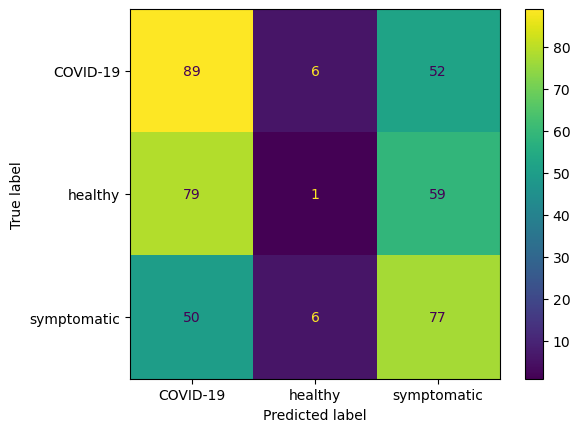

epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▇█
train_loss,▆▆▄▆█▆▆▇▆▇▆▆▇▆▆▅▅▅▆▆▆▆▅▇█▆▃▄▁▅▆▆▆▄▅▄▆▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_accuracy,▁▄█▅█
val_loss,█▁▃▁▁
epoch,5
test_accuracy,0.41527
test_loss,1.0804


wandb: Agent Starting Run: vgouh8bq with config:
wandb: 	augment_masking_val: min
wandb: 	batch_size: 32
wandb: 	dim: 64
wandb: 	heads: 4
wandb: 	max_epochs: 3
wandb: 	n_fft: 512
wandb: 	n_freq_masks: 2
wandb: 	n_mels: 64
wandb: 	n_time_masks: 1
wandb: 	sample_rate: 16000
wandb: 	spectrogram_type: mel-spectrogram
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/home/ubuntu/miniconda3/envs/deep_learning/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


Loading data...
Size of random sample of data: torch.Size([1, 64, 626])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | KWT  | 343 K 
-------------------------------
343 K     Trainable params
0         Non-trainable params
343 K     Total params
1.374     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 105/105 [01:08<00:00,  1.54it/s, v_num=h8bq, val_accuracy=0.353, train_accuracy=0.372]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 105/105 [01:08<00:00,  1.54it/s, v_num=h8bq, val_accuracy=0.353, train_accuracy=0.372]


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [13]:
sweep_config = {
  "method": "bayes",
  "metric": {
        "name": "val_accuracy",
        "goal": "maximize"
  },
  "parameters": {
    "batch_size": {
        "values": [8, 16, 32]
    },
    "max_epochs": {
        "values": [3, 5, 7]
    },
    "sample_rate": {
      "values": [16000] # Increasing this value will have a significant impact how much data you can fit into memory 48000 aprox double the size of 22050
    },
    "spectrogram_type": {
      "values": ['mel-spectrogram']
    },
    "n_fft": {
      "values": [512]
    },
    "n_mels": {
      "values": [32, 64]
    },
    "augment_masking_val": {
      "values": ['min', 'mean']
    },
    "n_freq_masks": {
      "values": [1, 2]
    },
    "n_time_masks": {
      "values": [1]
    },
    "dim": {
      "values": [16, 32, 64]
    },
    "heads": {
      "values": [4, 8]
    },
  }
}

sweep_id = wandb.sweep(sweep_config, project='cough-classifier', entity='dl-miniproject')

wandb.agent(sweep_id, function=train_new, count=100)
